In [3]:
# Imports
import glob
import time
import numpy as np
import cv2
from skimage.feature import hog
import os
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from scipy.ndimage.measurements import label
import pickle
from moviepy.editor import VideoFileClip
import collections

## Lesson functions

In [4]:
'''Functions defined in course material'''

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features 

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, bins_range=hist_range, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def draw_labeled_bboxes(img, labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bboxes

def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

## Visualization

In [19]:
def plot3d_test(img):
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)
    img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_RGB2YCrCb)
    img_rgb = img / 255.
    plot3d(img, img_rgb)
    plt.show()
    plot3d(img_small_YCrCb, img_rgb, axis_labels=list("YRB"))
    plt.show()    

<IPython.core.display.Javascript object>


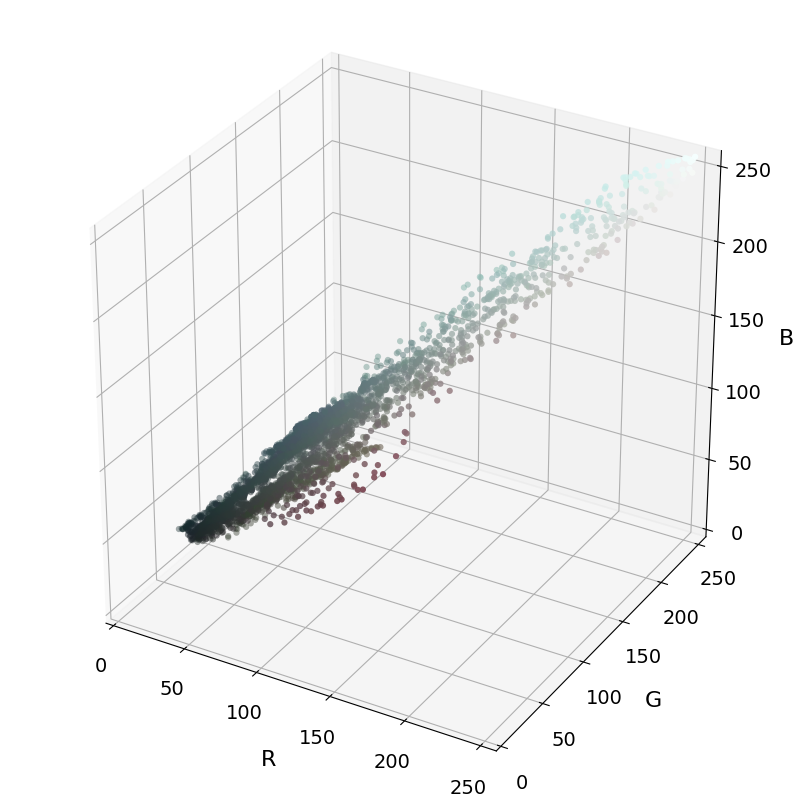

<IPython.core.display.Javascript object>


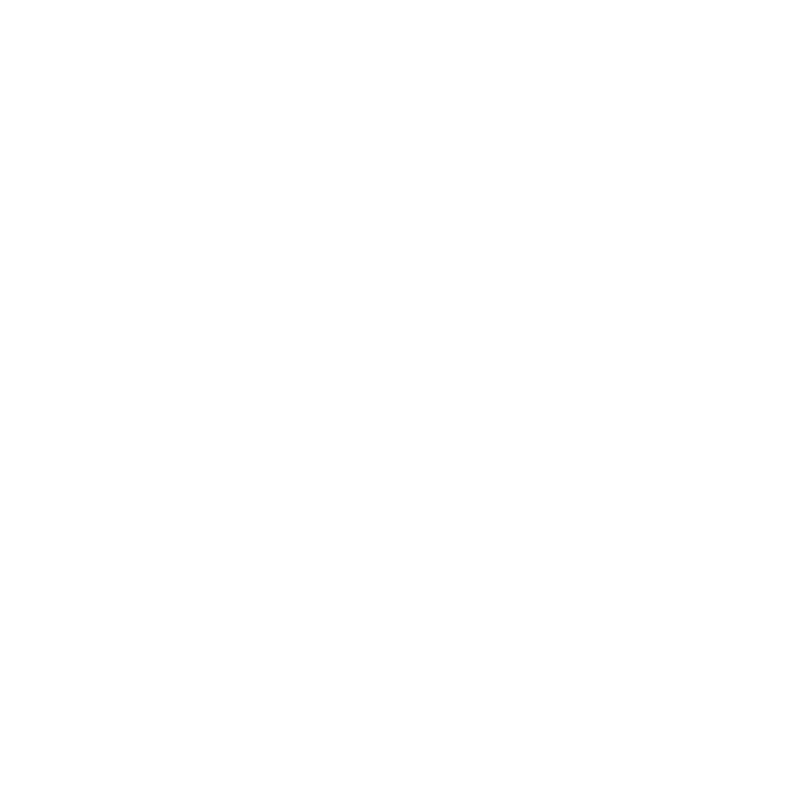

In [20]:
%matplotlib notebook
train_img = mpimg.imread('../vehicles/vehicles/GTI_Left/image0009.png')
train_img = train_img * 255.
plot3d_test(train_img)

In [57]:
def visualize_features(img_file, img_path):
    img_full_path = img_path + img_file
    img = mpimg.imread(img_full_path)
    img = cv2.resize(img, (128,128))
    mpimg.imsave('./output_images/' + img_file, img)
    img_conv = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    mpimg.imsave('./output_images/converted_' + img_file, img_conv)
    img_conv = img_conv * 255
    features_hog, img_hog = get_hog_features(img_conv[:,:,0], orient=9, pix_per_cell=8, cell_per_block=1, vis=True, feature_vec=True)
    mpimg.imsave('./output_images/hog_' + img_file, img_hog, cmap='gray')  
    spatial_features = bin_spatial(img_conv, color_space='RGB', size=(8, 8))
    plt.figure(figsize=(2,2))
    plt.plot(range(len(spatial_features)), spatial_features)
    plt.savefig('./output_images/spatial_' + img_file)
    plt.show()
    plt.clf()
    color_features = color_hist(img_conv, nbins=16, bins_range=(0, 256))
    plt.plot(range(len(color_features)), color_features)
    plt.savefig('./output_images/color_' + img_file)
    plt.show()
    plt.clf()

<IPython.core.display.Javascript object>


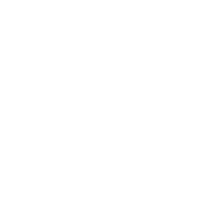

<IPython.core.display.Javascript object>


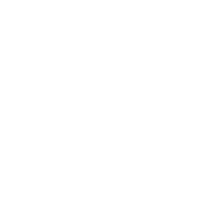

In [58]:
img_files = ['17.png', 'extra40.png']
img_paths = ['../vehicles/vehicles/KITTI_extracted/', '../non-vehicles/non-vehicles/Extras/']
for img_file, img_path in zip(img_files, img_paths):
    visualize_features(img_file, img_path)

## Extract features

In [ ]:
car_paths = ['../vehicles/vehicles/GTI_Far/image*.png',
            '../vehicles/vehicles/GTI_Left/image*.png',
            '../vehicles/vehicles/GTI_MiddleClose/image*.png',
            '../vehicles/vehicles/GTI_Right/image*.png',
            '../vehicles/vehicles/KITTI_extracted/*.png']
non_car_paths = ['../non-vehicles/non-vehicles/GTI/image*.png',
                '../non-vehicles/non-vehicles/Extras/extra*.png']

cars = []
non_cars = []
for car_path in car_paths:
    images = glob.glob(car_path)
    for image in images:
        cars.append(image)
for non_car_path in non_car_paths:
    images = glob.glob(non_car_path)
    for image in images:
        non_cars.append(image)

print('{} cars'.format(len(cars)))
print('{} non cars'.format(len(non_cars)))

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 1
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (8, 8)
hist_bins = 16
hist_range = (0, 256)

t=time.time()

# Extract features
car_features = []
non_car_features = []
for car in cars:
    img = mpimg.imread(car)
    #Add here rescaling between 0 and 255
    img = img * 255
    img = img.astype(np.uint8)
    car_features.append(single_img_features(img, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True))
for non_car in non_cars:
    img = mpimg.imread(non_car)
    #Add here rescaling between 0 and 255
    img = img * 255
    img = img.astype(np.uint8)
    non_car_features.append(single_img_features(img, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=hist_range, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

car_features = np.array(car_features)
non_car_features = np.array(non_car_features)
print('Features vector length: {}'.format(len(car_features[0])))

## Train classifier

In [ ]:
# Create an array stack of feature vectors
#X = np.vstack((np.concatenate((car_hog_features, car_spatial_color_features), axis=1), 
#               np.concatenate((non_car_hog_features, non_car_spatial_color_features), axis=1)))
X = np.vstack((car_features, non_car_features))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(cars)), np.zeros(len(non_cars))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = SVC(C=1e8, gamma=4e-4)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
#Save classifier
dict = {'clf': svc, 'scaler': X_scaler}
file = open('classifier.p', 'wb')
pickle.dump(dict, file)

## Test images

In [51]:
file = open('classifier.p', 'rb')
dict = pickle.load(file)
svc = dict['clf']
X_scaler = dict['scaler']

In [52]:
# Define a class to receive the characteristics of each line detection
class Car():
    def __init__(self):
        self.n = 10
        self.id = 0
        self.bboxes = collections.deque(maxlen=self.n)
        self.best_bbox = None
        self.visible = True
    def add_bbox(self, bbox):
        self.bboxes.append(bbox)
        self.best_bbox = np.mean(self.bboxes, axis=0).astype(np.int)

In [53]:
def process_image_zones(img, xy_window_sizes, x_start_stops, y_start_stops, threshold, debug=0, debug_dir='./', img_file='img.jpg'):
    window_list = []
    bboxes = []
    for i in range(len(xy_window_sizes)):
        xy_overlap = 1 - (16 / xy_window_sizes[i])
        slide_windows = slide_window(img, x_start_stop=[x_start_stops[i][0], x_start_stops[i][1]], 
                                        y_start_stop=[y_start_stops[i][0], y_start_stops[i][1]], 
                                        xy_window=(xy_window_sizes[i], xy_window_sizes[i]), 
                                        xy_overlap=(xy_overlap, xy_overlap))
        if (len(slide_windows) > 0):
            window_list.append(slide_windows)
    window_list = np.concatenate(window_list)
    on_windows = search_windows(img, window_list, svc, X_scaler, color_space='YCrCb', 
                    spatial_size=(8, 8), hist_bins=16, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=1, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
    if len(on_windows) > 0:
        if debug == 1:
            boxes_img = draw_boxes(img, on_windows)
            mpimg.imsave(debug_dir + 'boxes_' + img_file, boxes_img)
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,on_windows)
        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,threshold)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img, bboxes = draw_labeled_bboxes(img, labels)
    else:
        draw_img = np.copy(img)
    return draw_img, bboxes

def process_image(img, debug=0, debug_dir='./', img_file='img.jpg'):   
    global detected_cars, counter
    bboxes = []
    draw_img = np.copy(img)
    xy_window_sizes = [32, 64, 96, 128, 160, 192, 224]
    bboxes = []
    #print('counter is {}'.format(counter))
    if (counter % 10) == 0:  #trigger full search every 10 frames
        #print('Performing full search')
        x_start_stops = [[200, 1080], [100, 1180], [0, 1280], [0, 1280], [0, 1280], [0, 1280], [0, 1280]]
        y_start_stops = [[360, 550], [360, 550], [360, 650], [360, 650], [360, 650], [360, 650], [360, 650]]
        draw_img_tmp, bboxes = process_image_zones(img, xy_window_sizes, x_start_stops, y_start_stops, 1, 
                                                   debug=debug, debug_dir=debug_dir, img_file=img_file)
    else:   #otherwise search only vicinity of already found cars
        for detected_car in detected_cars:
            x_start_stops = []
            y_start_stops = []
            margin = 25
            for xy_window_size in xy_window_sizes:
                x_start_stops.append([detected_car.best_bbox[0][0]-margin, detected_car.best_bbox[1][0]+margin])
                y_start_stops.append([detected_car.best_bbox[0][1]-margin, detected_car.best_bbox[1][1]+margin])
            draw_img_tmp, bboxes_car = process_image_zones(img, xy_window_sizes, x_start_stops, y_start_stops, 0,
                                                      debug=debug, debug_dir=debug_dir, img_file=img_file)
            if len(bboxes_car) > 0:
                bboxes.append(bboxes_car)
        if len(bboxes) > 0:
            bboxes = np.concatenate(bboxes)
    #print('{} bboxes found'.format(len(bboxes)))
    #Hide all cars by default
    for detected_car in detected_cars:
        detected_car.visible = False
    #create OR update Car objects with each bbox found
    for bbox in bboxes:
        matchIndex = -1
        overlap = 0
        for i in range(len(detected_cars)):
            overlap_box = ((np.maximum(bbox[0][0], detected_cars[i].best_bbox[0][0]), np.maximum(bbox[0][1], detected_cars[i].best_bbox[0][1])),
                           (np.minimum(bbox[1][0], detected_cars[i].best_bbox[1][0]), np.minimum(bbox[1][1], detected_cars[i].best_bbox[1][1])))
            overlap_area = (overlap_box[1][0]-overlap_box[0][0])*(overlap_box[1][1]-overlap_box[0][1])
            if overlap_area > overlap:
                overlap = overlap_area
                matchIndex = i
        #print('Overlap {} for bbox {}'.format(overlap, bbox))
        if (overlap > 0):
            #print('Adding to existing car {}'.format(detected_cars[matchIndex].id))
            detected_cars[matchIndex].add_bbox(bbox)
            detected_cars[matchIndex].visible = True  #turn back on visible flag if overlap found
        else:
            detected_car = Car()
            detected_car.add_bbox(bbox)
            detected_cars.append(detected_car)
            detected_car.id = len(detected_cars)
            detected_car.visible = True  
            #print('Creating new car {}'.format(detected_car.id))
    #redraw best bboxes on original image
    best_bboxes = []
    for detected_car in detected_cars:
        if detected_car.visible == True:
            best_bboxes.append(detected_car.best_bbox)
        #else:
            #print('Car {} made invisible'.format(detected_car.id))
    draw_img = draw_boxes(draw_img, best_bboxes)
    counter += 1
    return draw_img

In [54]:
# Process test images
def process_test_images(debug=0, debug_dir='./'):
    global counter
    test_files = os.listdir('./test_images')
    for test_file in test_files:
        if test_file.endswith('jpg'):
            counter = 0
            img_file = './test_images/' + test_file
            print('Processing image {}'.format(test_file))
            img = mpimg.imread(img_file)
            res_img = process_image(img, debug=debug, debug_dir=debug_dir, img_file=test_file)
            mpimg.imsave(debug_dir + 'final_' + test_file, res_img)
            print('{} processed'.format(test_file))
            print('')

In [55]:
debug_dir = './test/'
if not os.path.isdir(debug_dir):
    os.mkdir(debug_dir)
detected_cars = []
counter = 0
process_test_images(debug=1, debug_dir=debug_dir)

Processing image test1.jpg
test1.jpg processed

Processing image test2.jpg
test2.jpg processed

Processing image test3.jpg
test3.jpg processed

Processing image test4.jpg
test4.jpg processed

Processing image test5.jpg
test5.jpg processed

Processing image test6.jpg
test6.jpg processed



In [56]:
img_file = 'bbox-example-image.jpg'
img_path = '../' + img_file
print('Processing image {}'.format(img_file))
img = mpimg.imread(img_path)
res_img = process_image(img, debug=1, debug_dir='./test/', img_file=img_file)
mpimg.imsave('./test/final_' + img_file, res_img)
print('{} processed'.format(img_file))
print('')

Processing image bbox-example-image.jpg
bbox-example-image.jpg processed




## Test video

In [9]:
output_dir = './output_images/'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
counter = 0
detected_cars = []
#video_file = 'test_video.mp4'
video_file = 'project_video.mp4'
video_output = output_dir + 'detected_vehicles_' + video_file
clip1 = VideoFileClip(video_file)
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/detected_vehicles_project_video.mp4
[MoviePy] Writing video ./output_images/detected_vehicles_project_video.mp4


100%|███████████████████████████████████▉| 1260/1261 [2:13:56<00:10, 10.74s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/detected_vehicles_project_video.mp4 

